Import Lib


In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from matplotlib import pyplot as plt, patches
import scipy.stats as ss
import cufflinks as cf
cf.go_offline()
from plotly.offline import iplot


Model design

In [2]:
# Config
# ticks = 3600 # 3600 ticks = 3600 seconds = 1 hour
ticks = 21600 # 3600 ticks = 3600 seconds = 6 hour
no_customers = 500
no_counters = 5
avg_service_time = 45 # ticks/seconds per customer
gross_margin_per_customer = 10 # dollars
cost_per_counter = 300 # dollars

In [3]:
def get_customers_arrived(model):
    customers_arrived = [customer._arrived for customer in model.customers]
    no_customers_arrived = np.sum(customers_arrived)
    return no_customers_arrived


def get_customers_served(model):
    customers_served = [not(customer._service_exit is None)
                        for customer in model.customers]
    no_customers_served = np.sum(customers_served)
    return no_customers_served


def get_customers_balked(model):
    customers_arrived = [customer._arrived for customer in model.customers]
    # Customers who never joined a queue
    customers_no_q = np.array(
        [customer._q_entry is None for customer in model.customers])
    no_customers_balked = np.sum(customers_arrived * customers_no_q)
    return no_customers_balked


def get_avg_queue_size(model):
    queue_size = [len(counter.queue) for counter in model.counters]
    avg_queue_size = np.mean(queue_size)
    return avg_queue_size


def get_avg_waiting_time(model):
    customers_wait = [np.nan if customer._q_exit is None else
                      customer._q_exit - customer._q_entry for customer in model.customers]
    avg_customer_wait = np.nanmean(customers_wait)
    return avg_customer_wait


def get_gross_margin(model):
    return gross_margin_per_customer * get_customers_served(model)


def get_operating_costs(model):
    return cost_per_counter * no_counters


def get_total_profit(model):
    return get_gross_margin(model) - get_operating_costs(model)


In [4]:
# no_customers
# a = ss.poisson(45).rvs()
# print(a)
# mu = 0.6
# mean, var, skew, kurt = ss.poisson.stats(mu, moments='mvsk')
# print(var)
# a = ss.poisson(45).rvs(15, loc=5, size=1, random_state=None)
a = ss.poisson.rvs(15, loc=5, random_state=None)
print(a)

20


In [5]:
class Customer(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # Time for customer shopping
        self.shopping_time = ss.poisson(45).rvs() 
        # self._shopping_entry
        # Time required to process the customer's transaction
        self.service_time = ss.poisson(45).rvs()
        self.shopping_time = ss.poisson(45).rvs()
        # Time of arrival at queue
        self.entry_time = (np.int(ss.beta(3, 3).rvs() * ticks) + 1) + self.shopping_time
        self.balk_tolerance = ss.poisson(5).rvs() + 1
        # # Shopping
        # self._shopping_entry = None
        # self._shopping_exit = None
        # self._enter_store = False
        # Time of entry and exit into the Store 
        self._shop_start = None
        self._shop_stop = None
        # Whether or not the customer has arrived at the queue
        self._arrived = False
        self._chosen_counter = None
        self._q_entry = None
        self._q_exit = None
        # Start time when customer is being served
        self._service_entry = None
        # End time
        self._service_exit = None
    # def go_shopping(self):
    #     self._enter_store = True
    #     # self._shopping_entry
    #     self.model._ #current time + shopping time, then set as model time for passing into queue
    def select_counter(self):
        self._arrived = True
        # Queue at shortest counter
        self._chosen_counter_idx = np.argmin([
            len(counter.queue) for counter in self.model.counters])
        self._chosen_counter = self.model.counters[self._chosen_counter_idx]
        # Balk if there are too many people at the counter
        if len(self._chosen_counter.queue) < self.balk_tolerance:
            self._chosen_counter.queue.append(self)
            self._q_entry = self.model._current_tick

    def pay_n_leave(self):
        self._service_exit = self.model._current_tick
        self._chosen_counter.active_customer = None

    def step(self):
        # if (self._enter_store == False) & (self.model._current_tick >= self._shop_start):
        #     self.go_shopping(self)
        if (self._arrived == False) & (self.model._current_tick >= self.entry_time):
            self.select_counter()
        elif isinstance(self._service_entry, int):
            if self.model._current_tick - self._service_entry == self.service_time:
                self.pay_n_leave()


class Counter(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.queue = []
        self.active_customer = None
        self.entry_time = np.int(ss.uniform().rvs() * ticks) + 1

    def dequeue(self):
        try:
            self.active_customer = self.queue.pop(0)
            self.active_customer._service_entry = self.model._current_tick
            self.active_customer._q_exit = self.model._current_tick
        except:
            pass

    def step(self):
        if self.active_customer is None:
            self.dequeue()
        # if 


class SMarket(Model):
    """Queueing model with customers and counters as two
    types of agents that interact with each other
    """

    def __init__(self, no_customers, no_counters, ticks):
        self.ticks = ticks
        self._current_tick = 1
        self.no_customers = no_customers
        self.no_counters = no_counters
        self.schedule = RandomActivation(self)
        # Create agents
        self.customers = []
        self.counters = []
        for i in range(self.no_customers):
            customer = Customer(i, self)
            self.schedule.add(customer)
            self.customers.append(customer)
        for i in range(self.no_counters):
            counter = Counter(i + no_customers, self)
            self.schedule.add(counter)
            self.counters.append(counter)
        self.datacollector = DataCollector(
            model_reporters={'Customers Arrived': get_customers_arrived,
                             'Customers Served': get_customers_served,
                             'Customers Balked': get_customers_balked,
                             'Average Waiting Time': get_avg_waiting_time,
                             'Average Queue Size': get_avg_queue_size,
                             'Gross Margin': get_gross_margin,
                             'Operating Costs': get_operating_costs,
                             'Total Profit': get_total_profit})

    def step(self):
        '''Advance the model by one step.'''
        self.datacollector.collect(self)
        self.schedule.step()
        self._current_tick += 1

SyntaxError: invalid syntax (2478793378.py, line 48)

Model execution

In [12]:
model = SMarket(ticks=ticks,
    no_customers=no_customers, no_counters=no_counters)

for i in range(ticks):
    model.step()

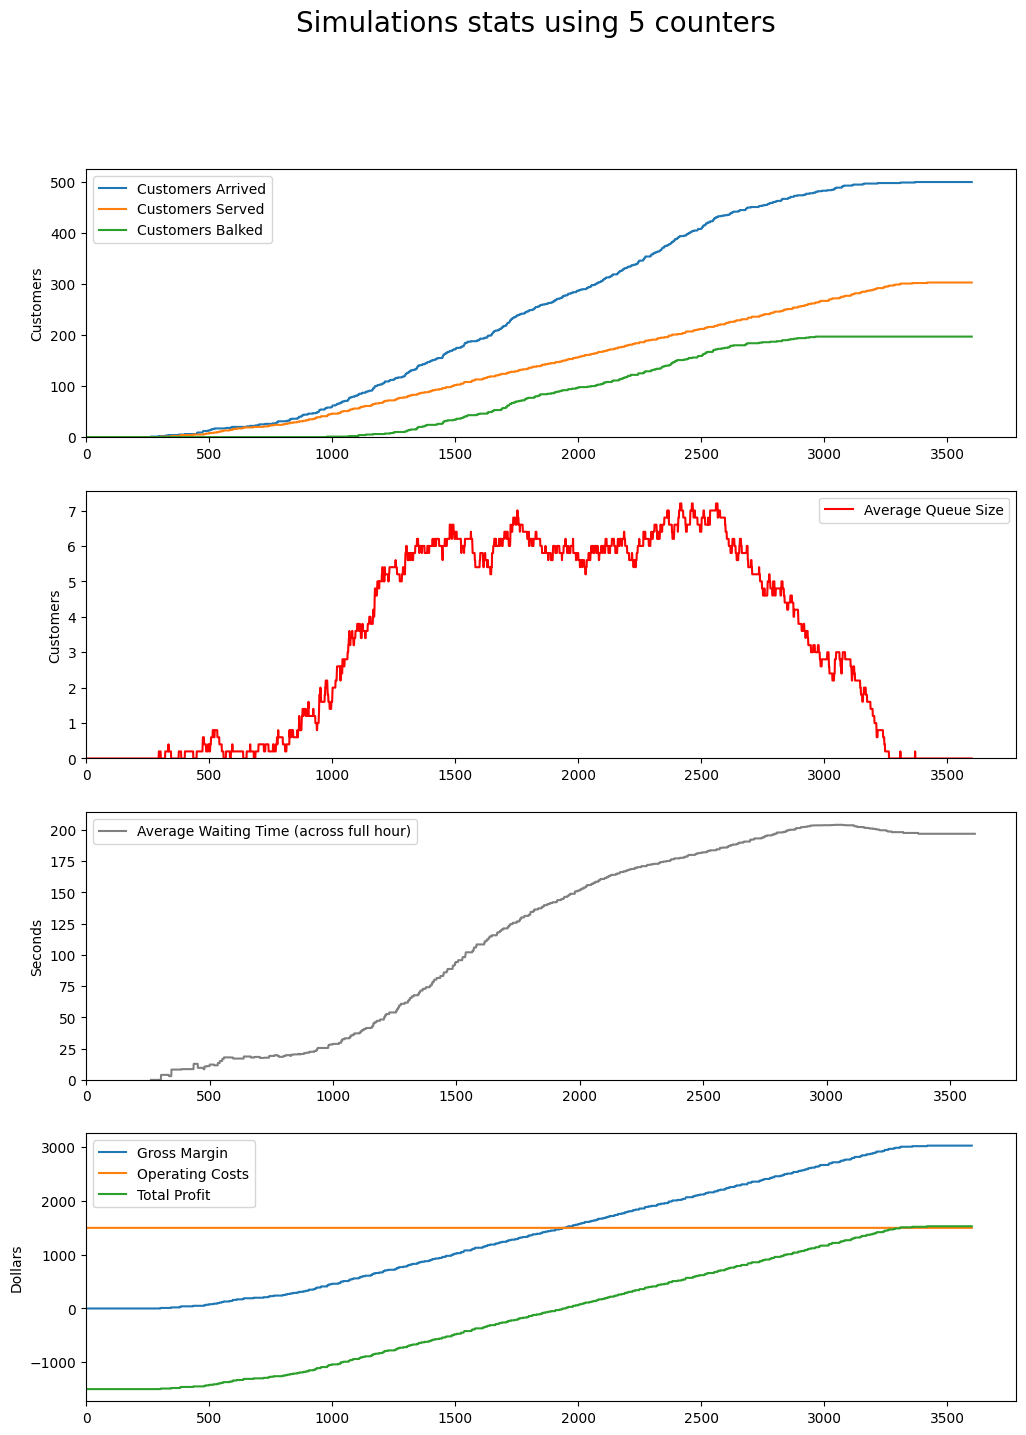

In [13]:
run_stats = model.datacollector.get_model_vars_dataframe()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.figure.set_figwidth(12)
fig.figure.set_figheight(16)
fig.suptitle(f'Simulations stats using {no_counters} counters', fontsize=20)

ax1.plot(run_stats[['Customers Arrived',
                'Customers Served',
                'Customers Balked',
               ]])
ax1.legend(['Customers Arrived',
            'Customers Served',
            'Customers Balked',
            ])
ax1.set_ylabel('Customers')
ax1.set_xlim(0)
ax1.set_ylim(0)

ax2.plot(run_stats['Average Queue Size'], color='red')
ax2.legend(['Average Queue Size'])
ax2.set_ylabel('Customers')
ax2.set_xlim(0)
ax2.set_ylim(0)

ax3.plot(run_stats['Average Waiting Time'], color='grey')
ax3.legend(['Average Waiting Time (across full hour)'])
ax3.set_ylabel('Seconds')
ax3.set_xlim(0)
ax3.set_ylim(0)

ax4.plot(run_stats[['Gross Margin',
                'Operating Costs',
                'Total Profit'
               ]])
ax4.legend(['Gross Margin',
            'Operating Costs',
            'Total Profit'
            ])
ax4.set_ylabel('Dollars')
ax4.set_xlim(0)

fig.show()



In [14]:
full_stats = {}

for no_counters in range (5, 16):
    model = QueueModel(ticks=ticks,
    no_customers=no_customers, no_counters=no_counters)
    for i in range(ticks):
        model.step()   
    run_stats = model.datacollector.get_model_vars_dataframe()
    full_stats[no_counters] = run_stats.iloc[-1]
    
pd.DataFrame(full_stats).transpose().astype(int)

,Customers Arrived,Customers Served,Customers Balked,Average Waiting Time,Average Queue Size,Gross Margin,Operating Costs,Total Profit
5,500,318,182,191,0,3180,1500,1680
6,500,349,151,174,0,3490,1800,1690
7,500,385,115,156,0,3850,2100,1750
8,500,439,61,126,0,4390,2400,1990
9,500,472,28,88,0,4720,2700,2020
10,500,481,19,91,0,4810,3000,1810
11,500,497,3,59,0,4970,3300,1670
12,500,500,0,36,0,5000,3600,1400
13,500,500,0,32,0,5000,3900,1100
14,500,500,0,29,0,5000,4200,800


In [ ]:
# To-do Add new shopping behaviour to Customer class which includes time delay
To D